In [10]:
import numpy as np
import pandas as pd
from matplotlib import pyplot
from sklearn.decomposition import PCA
import seaborn as sns

In [5]:
data = []
with open('./data/attention_to_emission_input.txt') as file:
    n, m = map(int, file.readline().split())
    print(n, m)
    data = [[float(i) for i in file.readline().split()] for i in range(n)]
    data = np.array(data)
pca = PCA(n_components=2)
d2 = pca.fit_transform(data)
d2.shape

50000 21


(50000, 2)

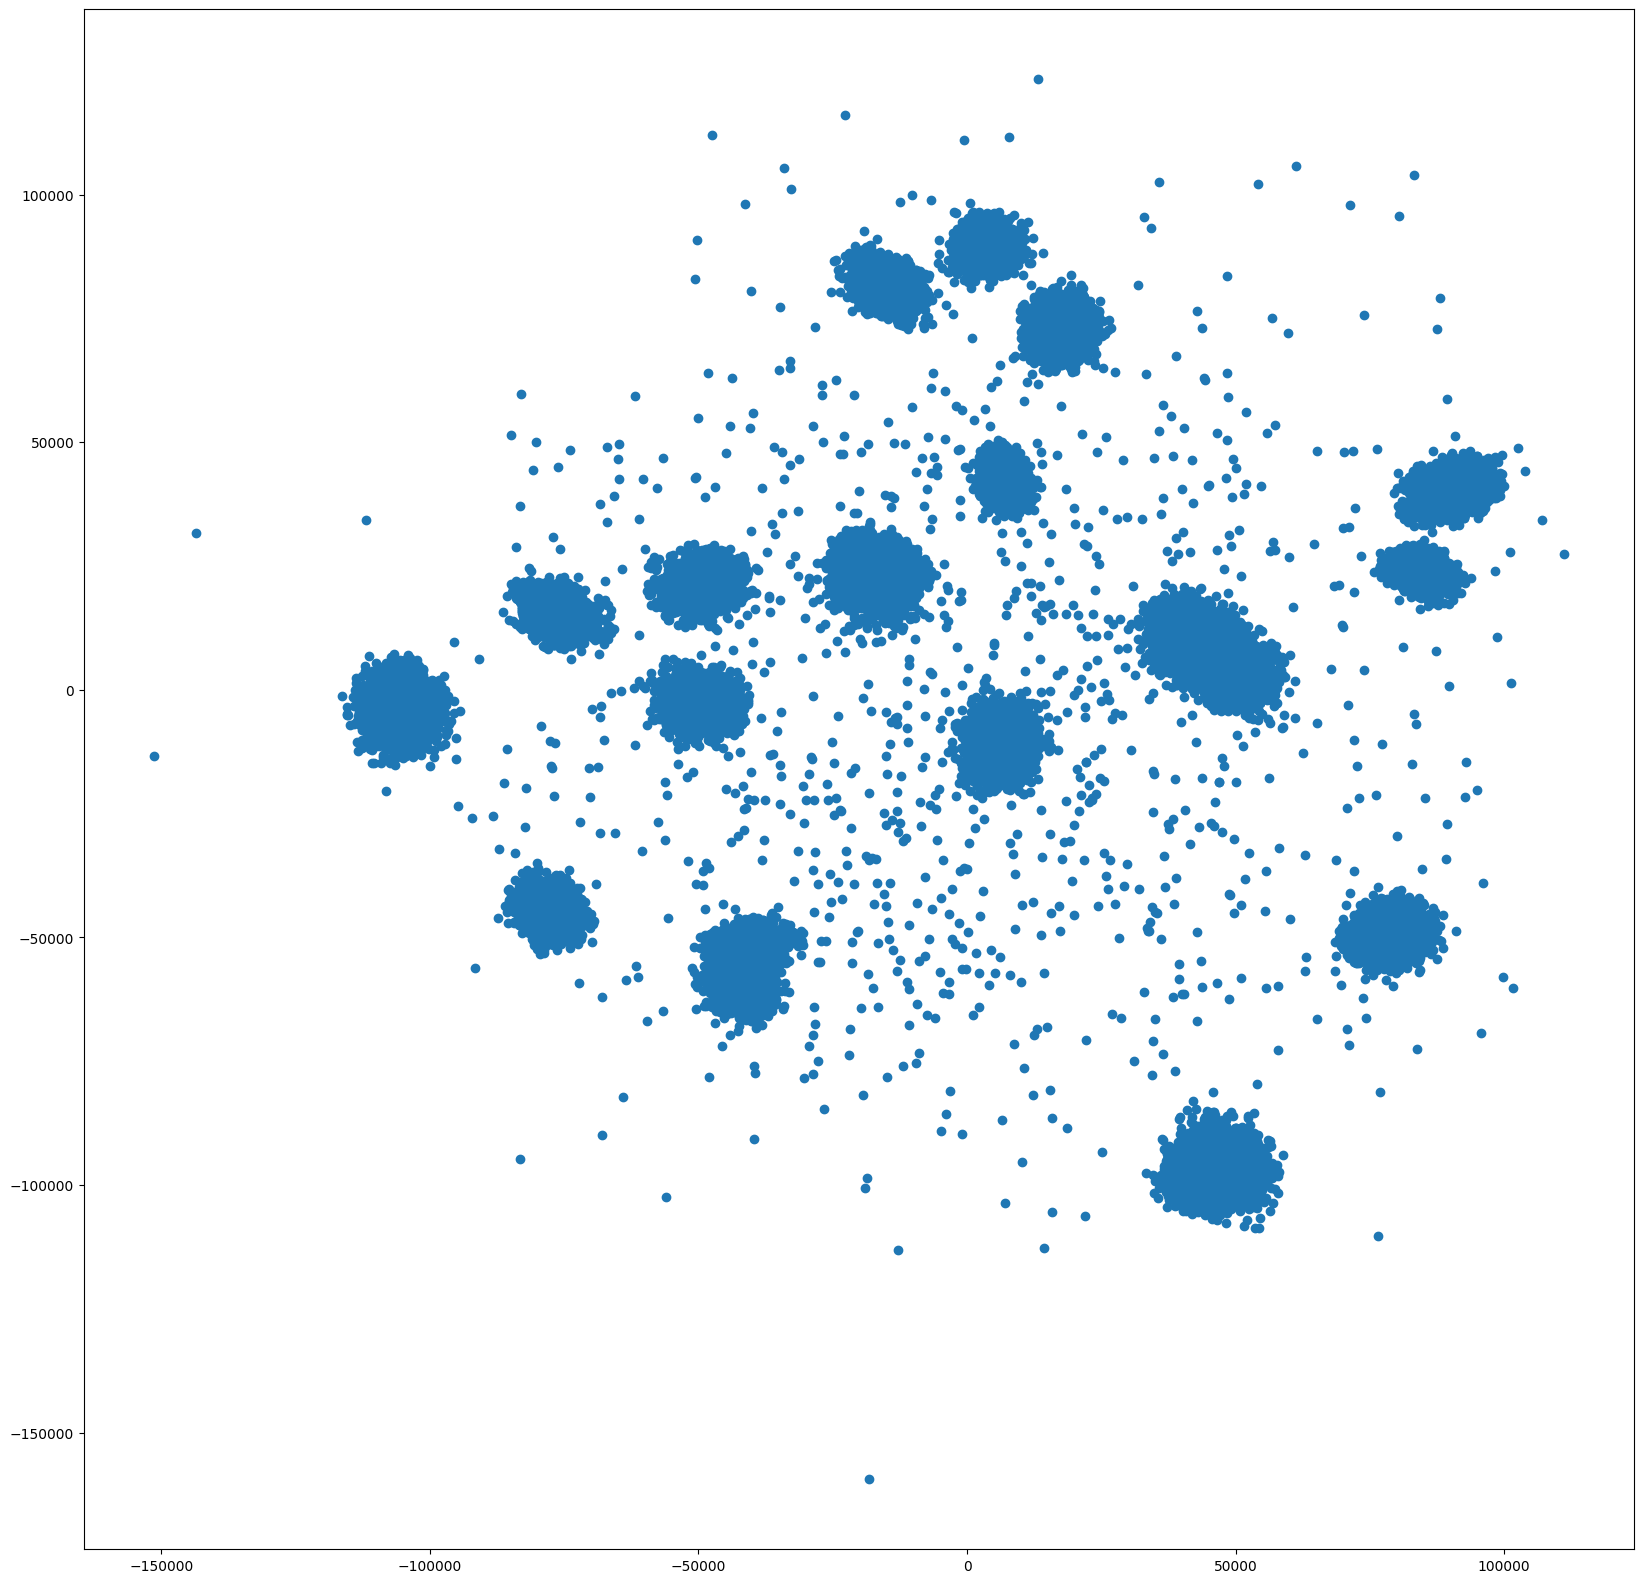

In [9]:
pyplot.figure(figsize=(20,20))
pyplot.scatter(d2[:, 0], d2[:, 1])

In [2]:
data2 = []
with open('./data/attention_to_emission_open_samples.txt') as file:
    n, m = map(int, file.readline().split())
    print(n, m)
    data2 = [[float(i) for i in file.readline().split()] for i in range(n)]
    data2 = np.array(data2)

pca = PCA(n_components=2)
d22 = pca.fit_transform(data2)
d22.shape


7916 19


(7916, 2)

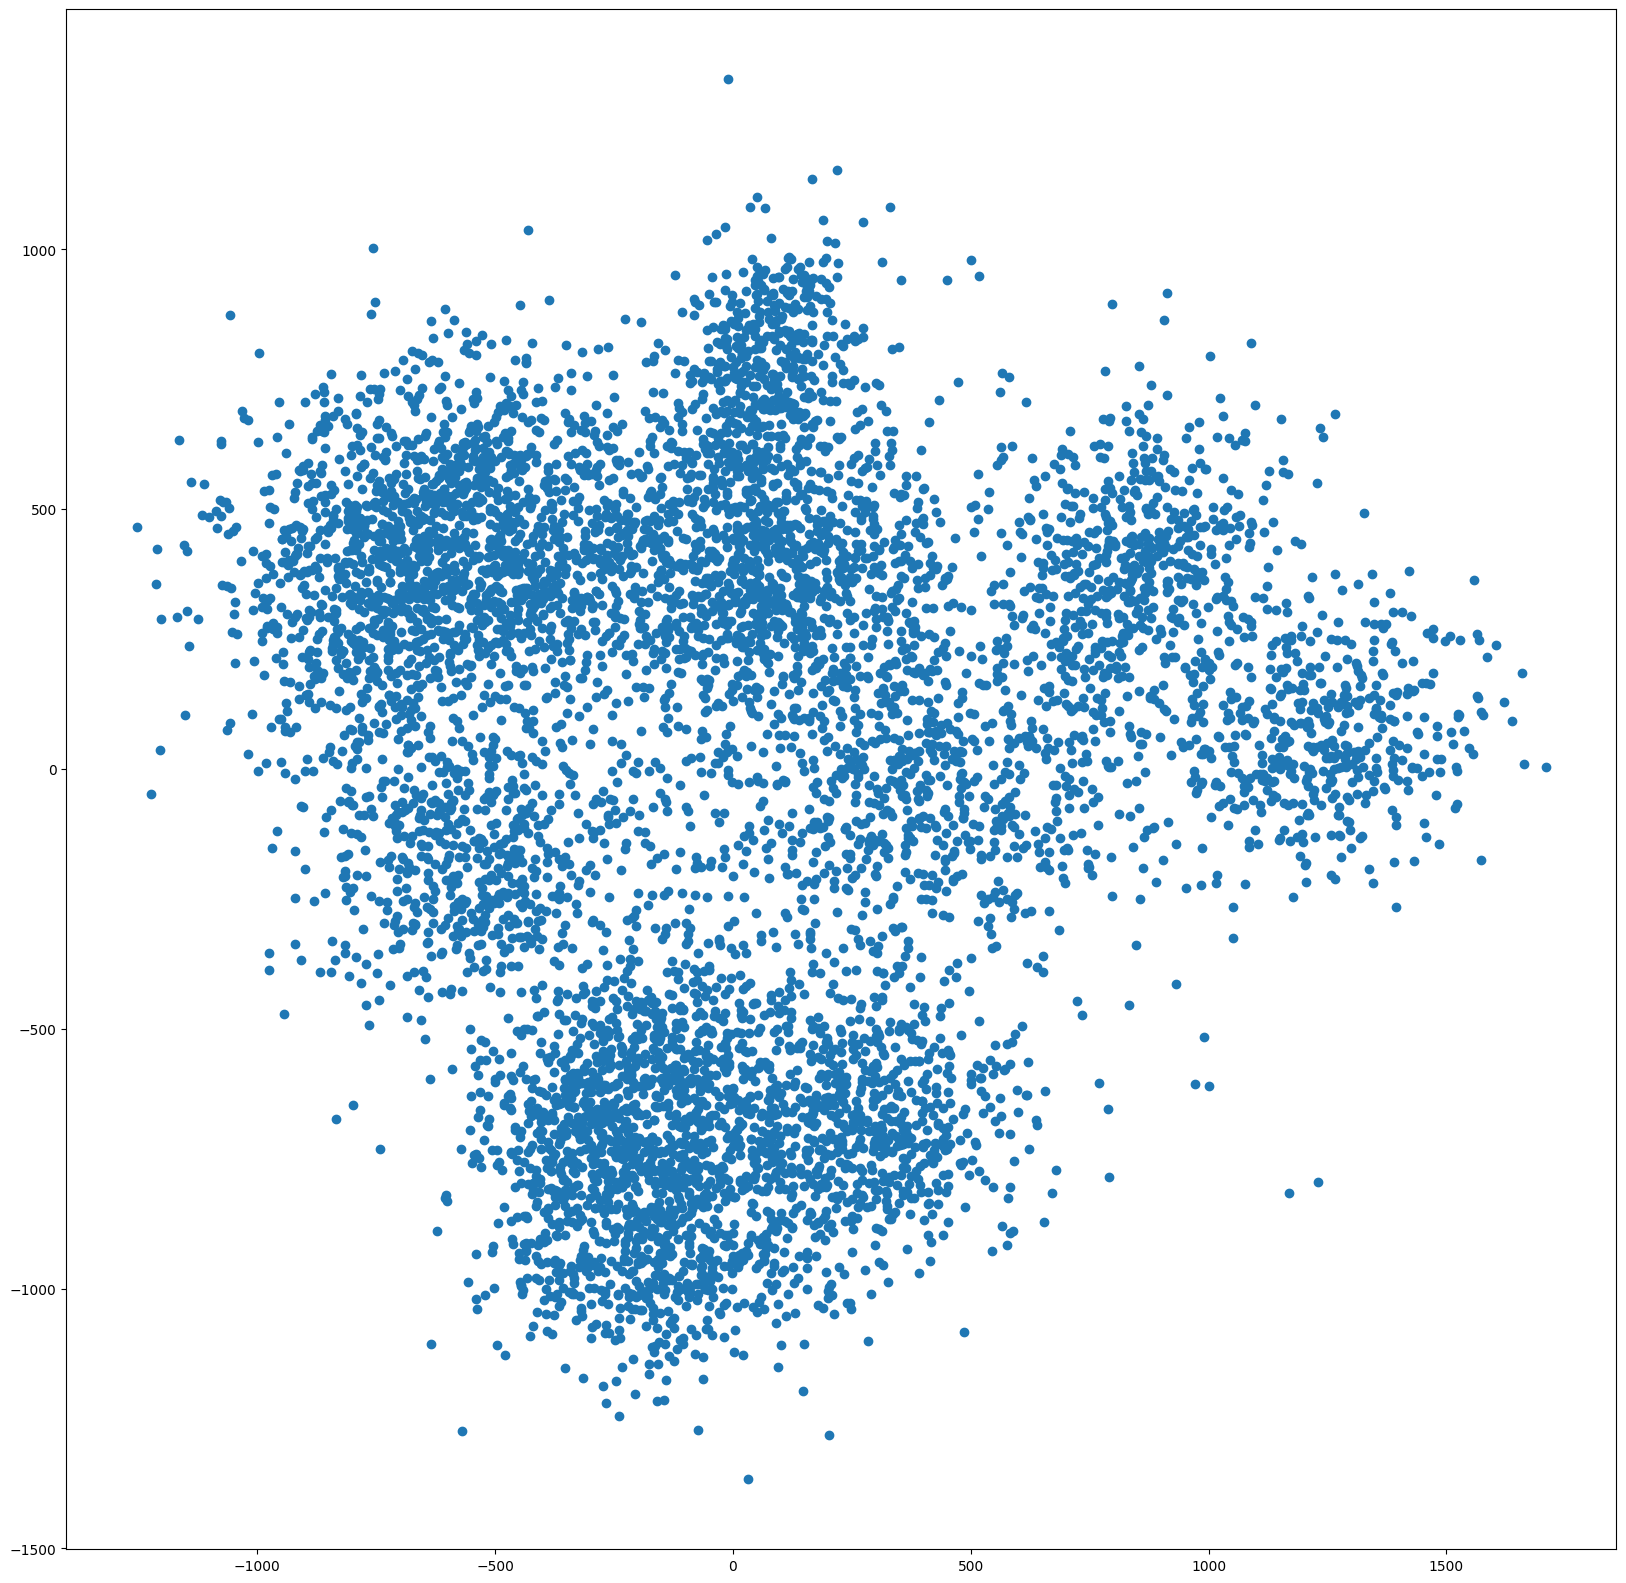

In [7]:
pyplot.figure(figsize=(20,20))
pyplot.scatter(d22[:, 0], d22[:, 1])

In [ ]:
pyplot.figure(figsize=(50,50))
sns.pairplot(pd.DataFrame(data[:, :3]))

<Figure size 5000x5000 with 0 Axes>